##### Shit we need

In [1]:
from qiskit import QuantumCircuit, Aer, transpile, IBMQ, providers
from qiskit.circuit import Parameter, ParameterVector
from qiskit.algorithms.optimizers import SPSA, ADAM
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Options, Session
from qiskit.utils import QuantumInstance


from tensorflow.keras.datasets import mnist, fashion_mnist

import numpy as np
from time import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math
import random
import csv

from IPython.display import clear_output

#provider = IBMQ.load_account()

### Setup of backend 
Here the backend is chosen and optional noise from real quantum computers is added to the simulation

In [2]:
shots = 1024

#To add noise change which backend is outcommented 
"""
simulatedBackend = provider.get_backend('ibmq_lima')

chosenBackend = AerSimulator.from_backend(simulatedBackend, #noisy simulator
                                          #max_parallel_threads=16,
                                          #max_parallel_experiments=0,#unlimited seems like better performance 259 vs 319 med det off
                                          shots=shots
                                        )
"""

chosenBackend = AerSimulator(method="statevector", #"perfect" simulator
                             #max_parallel_threads=16,
                             #max_parallel_experiments=0,
                             shots=shots
                            )

botInstance = QuantumInstance(backend=chosenBackend,
                              shots=shots,
                              optimization_level=3,
                             )

### Definition of circuits
Here both encoding and ansatz circuits are defined.
All circuits are made as circuits with unbound parameters 

In [3]:
def encodeValidation(n,dataLenght, reps):
    """
    
    """
    if (dataLenght % n) > 0 and (dataLenght / n) > reps:
         raise Exception("nr of features and encoding circuit doesn't match") 
    else:
        pass

    
def qcAnsatz2(qubits, nrT):
    """"
    This function generates ansatz circuit number 2
    Inputs are number of qubits and the number of parameters
    
    :param int qubits: The number of qubits in the circuit
    :param int nrT: The number of optimisation parameters which should be generated
    :return: Ansatz circuit
    """
    
    paraPrQ = 2
    paraPrL = paraPrQ * qubits
    reps = math.ceil(nrT/paraPrL)
    encodeValidation(qubits, nrT, reps) #checks wether or not nrT and qubits match
    
    theta_list = ParameterVector('θ', length=reps*paraPrL)
    circuit = QuantumCircuit(qubits)
    for j in range(reps):
        for i in range(qubits):
            circuit.rx(theta_list[j*paraPrL+i],i)
            circuit.ry(theta_list[j*paraPrL+i+qubits],i)
        
        for i in range((qubits-1),0,-1):
            circuit.cx(i,i-1)
            
        #circuit.barrier()
    return circuit
    
    
    
def qcAnsatz9(qubits, nrT):
    """"
    This function generates ansatz circuit number 9
    Inputs are number of qubits and the number of parameters
    
    :param int qubits: The number of qubits in the circuit
    :param int nrT: The number of optimisation parameters which should be generated
    :return: Ansatz circuit
    """
    
    paraPrQ = 1
    paraPrL = paraPrQ * qubits
    reps = math.ceil(nrT/paraPrL)
    
    encodeValidation(qubits, nrT, reps) #checks wether or not nrT and qubits match
    
    theta_list = ParameterVector('θ', length=reps*qubits)
    circuit = QuantumCircuit(qubits)

    for j in range(reps):
        circuit.h(range(qubits))
        for i in range(qubits-1):
            circuit.swap(i,i+1)
        
        for i in range(qubits):
            circuit.rx(theta_list[j*qubits+i], i)
            
        #circuit.barrier()
    return circuit


def qcAnsatzX(qubits, nrT):
    """"
    This function generates ansatz circuit number 9
    Inputs are number of qubits and the number of parameters
    
    :param int qubits: The number of qubits in the circuit
    :param int nrT: The number of optimisation parameters which should be generated
    :return: Ansatz circuit
    """
    
    paraPrQ = 1
    paraPrL = paraPrQ * qubits
    reps = math.ceil(nrT/paraPrL)
    
    encodeValidation(qubits, nrT, reps) #checks wether or not nrT and qubits match
    
    theta_list = ParameterVector('θ', length=reps*qubits)
    circuit = QuantumCircuit(qubits)

    for j in range(reps):
        circuit.h(range(qubits))
        for i in range(qubits-1):
            circuit.cx(i,i+1)
        
        for i in range(qubits):
            circuit.rx(theta_list[j*qubits+i], i)
            
        #circuit.barrier()
    return circuit


def qcAnsatz14(qubits, nrT):
    
    """
    This function generates ansatz circuit number 14
    Inputs are number of qubits and the number of parameters
    
    :param int qubits: The number of qubits in the circuit
    :param int nrT: The number of optimisation parameters which should be generated
    :return: Ansatz circuit
    """
    
    paraPrQ = 4
    paraPrL = paraPrQ * qubits
    reps = math.ceil(nrT/paraPrL)
    
    encodeValidation(qubits, nrT, reps) #checks wether or not nrT and qubits match
    
    theta_list = ParameterVector('θ', length=reps*paraPrL)
    circuit = QuantumCircuit(qubits)
    counter = 0
    for j in range(reps):
        for i in range(qubits):
            #circuit.ry(theta_list[j*paraPrL+i], i)
            circuit.ry(theta_list[counter], i)
            counter += 1
        
        #circuit.barrier()
        #circuit.crx(theta_list[j*paraPrL+qubits+1], nrT-1, 0)
        circuit.crx(theta_list[counter], qubits-1, 0)
        counter += 1
       
        if qubits > 2:
            for i in range((qubits-2),-1,-1):
                circuit.crx(theta_list[counter],i,i+1)
                counter += 1
                
        #circuit.barrier()

        for i in range(qubits):
            circuit.ry(theta_list[counter], i)
            counter += 1
        
        #circuit.barrier()

        circuit.crx(theta_list[counter], qubits-1, qubits-2)
        counter += 1
        circuit.crx(theta_list[counter], 0, qubits-1,)
        counter += 1
        if qubits > 2:
            for i in range(1,(qubits-1)):
                circuit.crx(theta_list[counter], i, i-1,)
                counter += 1
        
        #circuit.barrier()     
    return circuit
    


# data encoding function
def encode_ang(n, dataLen): # number of qubits, data
    """
    This function generates an angle encoding circuit which can be used to bind features
    Inputs are number of qubits and the number of parameters
    
    :param int n: The number of qubits in the circuit
    :param int dataLen: The number of encoded features 
    :return: encoded circuit
    """
    
    reps = 1
    
    encodeValidation(n, dataLen, reps)
    paraList = ParameterVector('X', length=dataLen)

    circuit = QuantumCircuit(n)

    
    for i in range(n):
        circuit.ry(paraList[i],i)
    return circuit
    
def encode_denseAng(n, dataLen): # number of qubits, data
    reps = 2
    encodeValidation(n, dataLen, reps)
    paraList = ParameterVector('X', length=dataLen)
    circuit = QuantumCircuit(n)
    for i in range(n):
        circuit.ry(paraList[i],i)
    for i in range(n):
        circuit.rz(paraList[i+n],i)
    return circuit
        
def encode_arb(n,dataLen):
    reps = 4
    encodeValidation(n, dataLen, reps)
    paraList = ParameterVector('X', length=dataLen)
    circuit = QuantumCircuit(n)
    for i in range(n):
        circuit.ry(paraList[i],i)
    for i in range(n):
        circuit.rz(paraList[i+n],i)
    circuit.barrier()
    for i in range(n-1):
        circuit.cx(i,i+1)
    circuit.barrier()
    for i in range(n):
        circuit.ry(paraList[i+2*n],i)
    for i in range(n):
        circuit.rz(paraList[i+3*n],i)
    return circuit

### Definition of PCA functions

In [4]:
def nDimPCA(dimOut, data):
    """
    Applies the PCA with to training data 
    
    :param int dimOut: Dimension of the output data
    :param np.array data: Matrices containing the training data
    :return: returns the reduced training data now in reduced dimension
    """
    #Normalize data
    #Flatten input data
    data = data.reshape([np.size(data,0),np.size(data,1)*np.size(data,2)])
    #Mean
    mu = np.mean(data, axis = 0)
    mu = mu.reshape([np.size(mu,0),1])
    #covariance
    data = np.transpose(data)
    sigma = np.cov(data-mu)
    #SVD
    U, S, V = np.linalg.svd(sigma)
    #V reduced
    VReduced = V[0:dimOut,0:]
    #output reduced data
    out = np.dot(VReduced,(data-mu))
    return np.transpose(out),mu,VReduced

def PCAOnTest(VReduced, mu, data):
    """
    Applies the PCA to test data
    
    :param np.array VReduced: Eigenvectors for the PCA
    :param np.array mu: Vector containing the mean values 
    :param np.array data: Matrices containing the test data
    :return: returns the reduced test data now in the same dimension as the training data
    """
    data = data.reshape([np.size(data,0),np.size(data,1)*np.size(data,2)])
    data = np.transpose(data)
    out = np.dot(VReduced,(data-mu))
    
    ### FEJL PROB HER
    #out = np.dot(np.transpose(VReduced),out)+mu
    
    return np.transpose(out)


def min_max_norm(data):
    """
    This function normalizes data to make it ready for encoding
    The input is the data of for example a picture
    Returns normalised data

    """
    maxVal = np.max(data)
    minVal = np.min(data)
    newData = np.pi*(np.subtract(data,minVal))/(maxVal-minVal)
    #newData = np.pi*data
    return newData

### Definition of functions for ML
Here we add a few functions and classes which will later be used for our ML

In [5]:
class OptimiserLog: #HEAVY INSPIRATION FROM QISKIT
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
        self.stepsize = []
    def update(self, evaluation, parameter, cost, stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)
        self.stepsize.append(stepsize)



def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()  

def load_reduced_data(keepClasses: list, qubitCount):
    """
    Takes a list of classes to keep and returns reduced mnist dataset.
    Loops over full data and appends to list if the class is in keepClasses.
    A list is used for performance reasons, since Numpy Append copies the entire array
    every time. The lists are cast to numpy array before returning.
    
    :param list keepClasses: List of ints.
    :return: returns two tuples. One with train data and one with test data.
    """
    transDict = {}
    for i in range(len(keepClasses)):
        transDict[keepClasses[i]] = i
    print(transDict)
    
    
    #fashion_mnist = fashion_mnist
    (train_images_full, train_labels_full), (test_images_full, test_labels_full) = fashion_mnist.load_data()
    
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []
    print("Loading train data")
    for i in tqdm(list(range(len(train_labels_full)))):
        if train_labels_full[i] in keepClasses:
            train_labels.append(transDict[train_labels_full[i]])
            train_images.append(train_images_full[i])
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    print("Loading test data")
    for i in tqdm(list(range(len(test_labels_full)))):
        if test_labels_full[i] in keepClasses:
            test_labels.append(transDict[test_labels_full[i]])
            test_images.append(test_images_full[i])
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)
    
    
    # Setup labels as vector outputs rather than digit value
    train_labelsVektor = np.zeros((qubitCount, len(train_labels)))
    for i in range(len(train_labels)):
        for j in range(len(keepClasses)):
            if train_labels[i] == j:
                train_labelsVektor[j, i] += 1
    train_labelsVektor = np.transpose(train_labelsVektor)

    test_labelsVektor = np.zeros((qubitCount, len(test_labels)))
    for i in range(len(test_labels)):
        for j in range(len(keepClasses)):
            if test_labels[i] == j:
                test_labelsVektor[j, i] += 1
    test_labelsVektor = np.transpose(test_labelsVektor)
    
    return (train_images, train_labelsVektor), (test_images, test_labelsVektor)

          

### Function for manual scoring of the parameters 
In order to check wether or not the classifier is overtrained we try and score the circuit with different parameters

In [6]:
def scoreParams(dataset, labels, parameters, vqc): # -> score
    score = 0
    for itera in range(len(dataset)):
        probs = vqc.neural_network.forward(dataset[itera], parameters)
        #print(probs, labels[itera])
        #print(int(max(probs, key=probs.get)), list(labels[itera]).index(max(labels[itera])))
        if list(probs[0]).index(max(probs[0])) == list(labels[itera]).index(max(labels[itera])):
            score += 1
    return score / len(dataset)

def scoreParamsByClass(dataset, labels, parameters, vqc): # -> score
    scores = [0] * len(labels[0])
    howManyOfEach = [0] * len(labels[0])
    for itera in range(len(dataset)):
        probs = vqc.neural_network.forward(dataset[itera], parameters)
        idx = list(labels[itera]).index(max(labels[itera]))
        howManyOfEach[idx] += 1
        if list(probs[0]).index(max(probs[0])) == idx:
            scores[idx] += 1

    for i, score in enumerate(scores):
        #print(score, howManyOfEach[i])
        scores[i] = score / howManyOfEach[i]
    return scores


def confusionMatrix(dataset, labels, parameters, vqc): # -> score
    scores = np.zeros((len(labels[0]),len(labels[0])))
    #howManyOfEach = [0] * len(labels[0])
    for itera in range(len(dataset)):
        probs = vqc.neural_network.forward(dataset[itera], parameters)
        idx = list(labels[itera]).index(max(labels[itera]))
        #howManyOfEach[idx] += 1
        predicted = list(probs[0]).index(max(probs[0]))
        scores[idx][predicted] += 1
    return scores


### Functions for writing to CSV
JONAS FIX HER

In [7]:
def saveALLToCSV(vqc, trainSize, testSize, logObj, features, testAccuracy, trainAccuracy, ansatzName):
    with open('spsaTime' + '.csv', 'w', encoding='UTF8') as f:
        writer = csv.writer(f)
        writer.writerow(['Number of qubits: ' + str(vqc.num_qubits)])
        writer.writerow(['Training set size: ' + str(trainSize)])
        writer.writerow(['Test set size: ' + str(testSize)])
        writer.writerow(['Number of features: ' + str(features)])
        writer.writerow(['Ansatz: ' + str(ansatzName)])
        writer.writerow(['Optimiser: ' + str(vqc.optimizer.__class__)])
        writer.writerow(['Perturbation dimensions: ' + str(vqc.optimizer.perturbation_dims)])
        writer.writerow(['Training accuracy', 'Test accuracy', 'Parameters'])
        for i in range(len(trainAccuracy)):
            writer.writerow([trainAccuracy[i], testAccuracy[i], logObj.parameters[i]])
                         
def saveResultToCSV(vqc, trainSize, testSize, logObj, features, testAccuracy, trainAccuracy, ansatzName):
    with open('./results/' + 'TEST' + '/' + str(ansatzName) + '___' + str(len(logObj.parameters[0])) + '.csv', 'w', encoding='UTF8') as f:
        writer = csv.writer(f)
        writer.writerow(['Number of qubits: ' + str(vqc.num_qubits)])
        writer.writerow(['Training set size: ' + str(trainSize)])
        writer.writerow(['Test set size: ' + str(testSize)])
        writer.writerow(['Number of features: ' + str(features)])
        writer.writerow(['Ansatz: ' + str(ansatzName)])
        writer.writerow(['Optimiser: ' + str(vqc.optimizer.__class__)])
        writer.writerow(['Perturbation dimensions: ' + str(vqc.optimizer.perturbation_dims)])
        writer.writerow(['Training accuracy', 'Test accuracy'])
        for i in range(len(trainAccuracy)):
            writer.writerow([trainAccuracy[i], testAccuracy[i]])

# Options for the VQC
Here you choose everything except backend and shots

In [8]:
keepList = [0, 1, 2, 3, 4] #Which classes do we want to use in our machine learning
nrQ = 5   #Qubits in circuits, should match number of classes
nrThetas = nrQ*4 #number of parameters to optimise
wantedFeatures = nrQ*2 #number of features to encode into the circuit


encodedCircuit = encode_denseAng(nrQ, wantedFeatures)
ansatz = qcAnsatz2(nrQ,nrThetas)

#Optimiser options
perturbationDims=int(np.ceil(0.75*nrThetas))

lossFunction = 'cross_entropy' #other options include 'absolute_error' and 'cross_entropy' 'squared_error'

#Validation settings
scoreStep = 10 #Steps in epochs between accuracy scores e.g. if 10: 0, 10, 20...

#Training options
trainSize = 128 #total trainset size
testSize = 128
epochs = 10 #epochs in total

#batch options. If batch = false none of the options here are relevant
#both perturbationSize and learning rate can also be given as an array with length epoch/batchCount for
batch = True
batchCount = 2 #how many batches the training will be divided into
perturbationSize = 0.05 #How big the perturbation in each dimension will be
learningRateStart = 0.1 
learningRateStop = 0.001

### Load and reduce data
Here the data and labels are loaded

The data is normalised so it is ready to be encoded

PCA is also used here

In [9]:
OGclass_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_names = [OGclass_names[i] for i in keepList]
(train_images, train_labelsVektor), (test_images, test_labelsVektor) = load_reduced_data(keepList, nrQ) #load
train_images = train_images / 255.0 #Normalize
test_images = test_images / 255.0

#PCA
reducedTrain, mean, VRed = nDimPCA(wantedFeatures, train_images)
reducedTest = PCAOnTest(VRed,mean,test_images)

#Normalising the data from 0 to pi
reducedTrain = min_max_norm(reducedTrain)
reducedTest = min_max_norm(reducedTest)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
Loading train data


  0%|          | 0/60000 [00:00<?, ?it/s]

Loading test data


  0%|          | 0/10000 [00:00<?, ?it/s]

### Running the VQC

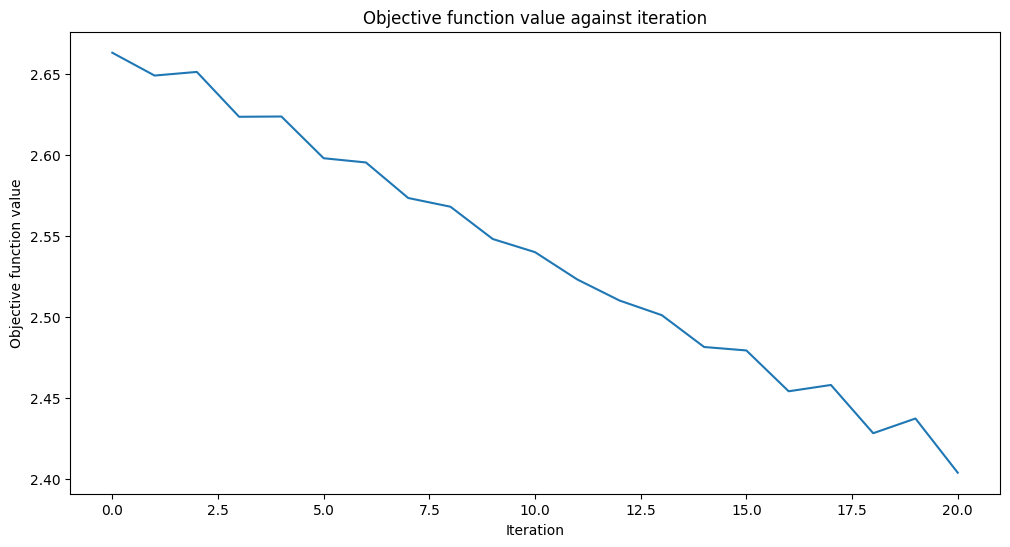

[7750.149596214294]
[]
[]


In [10]:
encodedCircuitTP = transpile(encodedCircuit, chosenBackend, optimization_level=3)
ansatzTP = transpile(ansatz, chosenBackend, optimization_level=3)
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
log = OptimiserLog()
trainResult = []
testResult = []
timer = [] 

changingLearningRate = np.logspace(-2.3, -4.6, num=epochs, base=np.e)


optimiserOBJ = ADAM(maxiter = epochs,
                   )
OGvqc = VQC(feature_map=encodedCircuitTP,
          ansatz=ansatzTP,
          loss=lossFunction,
          optimizer=optimiserOBJ,
          callback=callback_graph,
          quantum_instance=botInstance,
         )

nu = time()
if batch == True:
    optimiserOBJ.maxiter = 1
    batchSize = int(trainSize/batchCount)
    #OGvqc.fit(reducedTrain[:batchSize], train_labelsVektor[:batchSize]) # to get some initial values
    
    
    
    

    #initial small training to get the optimisation started
    OGvqc.fit(reducedTrain[:batchSize], train_labelsVektor[:batchSize]) # to get some initial values
    OGvqc.warm_start = True
   

    for epochCounter in range(epochs):
        #optimiserOBJ.learning_rate = changingLearningRate[epochCounter]
        for i in range(batchCount):
            OGvqc.fit(reducedTrain[i*batchSize:(i+1)*batchSize], train_labelsVektor[i*batchSize:(i+1)*batchSize])
        #testResult.append(OGvqc.score(reducedTest[:testSize], test_labelsVektor[:testSize]))
        #OGvqc.save("VQCModelMANYPAR")
        #trainResult.append(OGvqc.score(reducedTrain[:trainSize], train_labelsVektor[:trainSize]))
    timer.append(time() - nu)
    


else: 
    OGvqc.fit(reducedTrain[:trainSize], train_labelsVektor[:trainSize])
    #testResult.append(OGvqc.score(reducedTest[:testSize], test_labelsVektor[:testSize]))
    #OGvqc.save("VQCModelMANYPAR")
    #trainResult.append(OGvqc.score(reducedTrain[:trainSize], train_labelsVektor[:trainSize]))
    timer.append(time() - nu)


print(timer)
print(testResult)
print(trainResult)

### Plot of the 'nice' training

c:\Users\nikol\Anaconda3\envs\qiskit\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nikol\Anaconda3\envs\qiskit\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


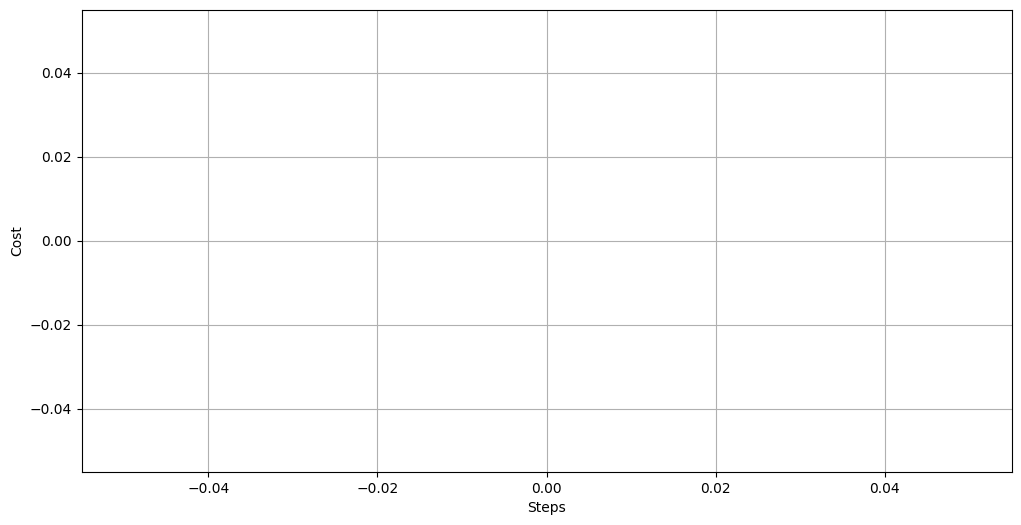

In [11]:
fig = plt.figure()
if batch == True:
    avgCost = []
    for i in range(epochs):
        avgCost.append(np.mean(log.costs[i*batchCount:(i+1)*batchCount])) #average of the batch costs
    #plt.plot(range((epochs*batchCount)+1), log.costs)
    plt.plot(range(epochs), avgCost)


else: 
    plt.plot(range(epochs), log.costs)
    
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.grid()
plt.show()

In [12]:
from qiskit.tools.jupyter import *
%qiskit_version_table